# FetchReachDense-v4 — Entrenamiento PPO (Gymnasium Robotics)

Este notebook entrena un agente PPO para la tarea `FetchReachDense-v4` usando aprendizaje por refuerzo. **Incluye sistema completo de entrenamiento y evaluación** con compatibilidad total para Colab y ejecución local.

**Características:**
- 🤖 Entrenamiento PPO optimizado para manipulación robótica
- 📊 Logging detallado con TensorBoard
- 📹 Video de evaluación de alta calidad
- 🖥️ Compatible con Colab, MPS (Apple Silicon) y CUDA
- 🌐 Configuración automática para diferentes entornos
- 📈 Evaluación cuantitativa y guardado de modelos

**Entorno:** Robot Fetch reaching to target positions with dense rewards.

Refs: `https://robotics.farama.org/envs/fetch/reach/`

In [ ]:
# 🔧 Instalación de dependencias y configuración de entorno
import os, sys, subprocess
IN_COLAB = ('COLAB_GPU' in os.environ) or ('COLAB_RELEASE_TAG' in os.environ)
print('IN_COLAB =', IN_COLAB)

if IN_COLAB:
    print("🔧 Instalando dependencias en Colab...")
    try:
        # Instalar dependencias del sistema
        subprocess.run(['apt-get', 'update', '-qq'], check=True)
        subprocess.run(['apt-get', 'install', '-y', '-qq', 'libosmesa6-dev', 'libgl1-mesa-glx', 'libglfw3', 'patchelf', 'xvfb', 'ffmpeg'], check=True)
        print("✅ Dependencias del sistema instaladas")
    except Exception as e:
        print('⚠️ apt-get skipped/error:', e)

    # Actualizar pip e instalar paquetes Python
    subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', '--upgrade', 'pip'], check=True)
    subprocess.run([sys.executable, '-m', 'pip', 'install', '-q',
                    'gymnasium[other]', 'gymnasium-robotics', 'mujoco', 'glfw', 'imageio[ffmpeg]',
                    'pyvirtualdisplay', 'stable-baselines3', 'sb3-contrib', 'tensorboard'], check=True)
    print("✅ Paquetes Python instalados")

    # Conectar Google Drive para persistencia (opcional)
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("✅ Google Drive montado en /content/drive")
    except:
        print("⚠️ No se pudo montar Google Drive (opcional)")

    # Limpiar output para mejor presentación
    from IPython.display import clear_output
    clear_output()
    print("✅ Todas las dependencias han sido instaladas correctamente en Colab.")

else:
    print('🏠 Ejecución local detectada')
    print('💡 Usa requirements.txt: pip install -r requirements.txt')
    print('📋 Dependencias necesarias: gymnasium, gymnasium-robotics, mujoco, stable-baselines3, imageio[ffmpeg]')

    # Verificar dependencias críticas
    try:
        import gymnasium
        import gymnasium_robotics
        import stable_baselines3
        import imageio
        print('✅ Dependencias críticas verificadas')
    except ImportError as e:
        print(f'❌ Dependencia faltante: {e}')
        print('🔧 Instala con: pip install -r requirements.txt')

✅ Todas las dependencias han sido instaladas correctamente en Colab.


In [ ]:
# ⚙️ Configuración del experimento y verificación del entorno
import os
import numpy as np
import gymnasium as gym
import gymnasium_robotics  # noqa: F401
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from stable_baselines3.common.logger import configure
from pathlib import Path
import time

# Configuración de display virtual para video rendering en Colab
if IN_COLAB:
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()
    print("✅ Display virtual iniciado para Colab")

# Configuración de device (CUDA preferido en Colab, CPU como fallback)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Configuración del experimento
ENV_ID = 'FetchReachDense-v4'
SEED = 42
EXPERIMENT_NAME = f"{ENV_ID}_PPO_{int(time.time())}"
EXPERIMENT_NAME = "FetchReachDense-v4_PPO_1758579285"
# Rutas para checkpoints y modelos - SIEMPRE usar Google Drive en Colab
if IN_COLAB:
    if not os.path.exists('/content/drive'):
        print("⚠️ Google Drive no está montado. Montando...")
        from google.colab import drive
        drive.mount('/content/drive')

    BASE_DIR = f"/content/drive/MyDrive/RL_Experiments/{EXPERIMENT_NAME}"
    print(f"📁 Usando Google Drive para persistencia: {BASE_DIR}")
else:
    BASE_DIR = f"./{EXPERIMENT_NAME}"
    print(f"📁 Usando directorio local: {BASE_DIR}")

LOG_DIR = os.path.join(BASE_DIR, "logs")
MODEL_DIR = os.path.join(BASE_DIR, "models")
CHECKPOINT_DIR = os.path.join(BASE_DIR, "checkpoints")
VIDEO_DIR = os.path.join(BASE_DIR, "videos")

# Crear directorios
for dir_path in [LOG_DIR, MODEL_DIR, CHECKPOINT_DIR, VIDEO_DIR]:
    os.makedirs(dir_path, exist_ok=True)

print(f"🔧 Configuración:")
print(f"   Device: {device}")
print(f"   Environment: {ENV_ID}")
print(f"   Experiment: {EXPERIMENT_NAME}")
print(f"   Base directory: {BASE_DIR}")
print(f"   Gymnasium: {gym.__version__}")
print(f"   PyTorch: {torch.__version__}")

def make_env():
    """Crea entorno Fetch con configuración estándar"""
    env = gym.make(ENV_ID, render_mode='rgb_array')
    env = Monitor(env)
    return env

# Verificar que el entorno funciona
print("🧪 Verificando entorno...")
test_env = make_env()
obs, info = test_env.reset(seed=SEED)
print(f"   Observation space: {test_env.observation_space}")
print(f"   Action space: {test_env.action_space}")
print(f"   Observation keys: {list(obs.keys()) if isinstance(obs, dict) else 'Box space'}")

# Verificar que el rendering funciona
test_frame = test_env.render()
print(f"   Render frame shape: {test_frame.shape if test_frame is not None else 'None'}")

test_env.close()
print("✅ Entorno verificado y listo para entrenamiento/evaluación")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✅ Display virtual iniciado para Colab
📁 Usando Google Drive para persistencia: /content/drive/MyDrive/RL_Experiments/FetchReachDense-v4_PPO_1758579285
🔧 Configuración:
   Device: cuda
   Environment: FetchReachDense-v4
   Experiment: FetchReachDense-v4_PPO_1758579285
   Base directory: /content/drive/MyDrive/RL_Experiments/FetchReachDense-v4_PPO_1758579285
   Gymnasium: 1.2.0
   PyTorch: 2.8.0+cu126
🧪 Verificando entorno...
   Observation space: Dict('achieved_goal': Box(-inf, inf, (3,), float64), 'desired_goal': Box(-inf, inf, (3,), float64), 'observation': Box(-inf, inf, (10,), float64))
   Action space: Box(-1.0, 1.0, (4,), float32)
   Observation keys: ['observation', 'achieved_goal', 'desired_goal']
   Render frame shape: (480, 480, 3)
✅ Entorno verificado y listo para entrenamiento/evaluación


In [ ]:
# 🚀 Entrenamiento PPO con sistema de checkpoints automáticos

def find_latest_checkpoint():
    """Busca el último checkpoint guardado"""
    checkpoint_files = list(Path(CHECKPOINT_DIR).glob("rl_model_*_steps.zip"))
    if not checkpoint_files:
        return None, 0

    # Extraer número de steps de cada archivo
    steps = []
    for file in checkpoint_files:
        try:
            step_num = int(file.stem.split('_')[-2])
            steps.append((step_num, file))
        except:
            continue

    if not steps:
        return None, 0

    # Retornar el checkpoint con más steps
    latest_steps, latest_file = max(steps, key=lambda x: x[0])
    return str(latest_file), latest_steps

def create_model():
    """Crea un nuevo modelo PPO configurado para FetchReachDense"""
    # Entorno de entrenamiento
    train_env = VecMonitor(DummyVecEnv([make_env]))

    # Configurar logger para TensorBoard
    new_logger = configure(LOG_DIR, ['stdout', 'tensorboard'])

    # Configuración de red neuronal optimizada para FetchReach
    policy_kwargs = dict(
        activation_fn=torch.nn.ReLU,
        net_arch=dict(pi=[256, 256], vf=[256, 256])
    )

    # Crear modelo PPO con hiperparámetros optimizados
    model = PPO(
        'MultiInputPolicy',  # FetchReach usa observaciones dict
        train_env,
        verbose=1,
        seed=SEED,
        tensorboard_log=LOG_DIR,
        n_steps=2048,
        batch_size=256,
        gae_lambda=0.95,
        n_epochs=10,
        gamma=0.98,
        learning_rate=3e-4,
        clip_range=0.2,
        ent_coef=0.0,
        policy_kwargs=policy_kwargs,
        device=device
    )

    model.set_logger(new_logger)
    return model, train_env

# Buscar checkpoint existente
latest_checkpoint, completed_steps = find_latest_checkpoint()

if latest_checkpoint:
    print(f"🔄 Reanudando desde checkpoint: {latest_checkpoint}")
    print(f"   Steps completados: {completed_steps:,}")

    # Cargar modelo desde checkpoint
    model = PPO.load(latest_checkpoint, device=device)
    train_env = VecMonitor(DummyVecEnv([make_env]))
    model.set_env(train_env)

    # Reconfigurar logger
    new_logger = configure(LOG_DIR, ['stdout', 'tensorboard'])
    model.set_logger(new_logger)
else:
    print("🆕 Iniciando entrenamiento nuevo")
    model, train_env = create_model()
    completed_steps = 0

# Configurar callbacks
eval_env = VecMonitor(DummyVecEnv([make_env]))

# Checkpoint callback - guarda cada 25k steps (más frecuente para sessiones de Colab)
checkpoint_callback = CheckpointCallback(
    save_freq=25_000,
    save_path=CHECKPOINT_DIR,
    name_prefix='rl_model',
    save_replay_buffer=True,
    save_vecnormalize=True,
    verbose=1
)

# Eval callback - evalúa y guarda mejor modelo cada 10k steps
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=MODEL_DIR,
    log_path=LOG_DIR,
    eval_freq=10_000,
    n_eval_episodes=10,
    deterministic=True,
    render=False,
    verbose=1
)

# Combinar callbacks
callback_list = CallbackList([checkpoint_callback, eval_callback])

# Configuración de entrenamiento
TOTAL_TIMESTEPS = 200_000  # Total objetivo
remaining_steps = TOTAL_TIMESTEPS - completed_steps

if remaining_steps > 0:
    print(f"� Iniciando entrenamiento:")
    print(f"   Steps restantes: {remaining_steps:,}")
    print(f"   Steps totales objetivo: {TOTAL_TIMESTEPS:,}")
    print(f"   Checkpoints cada: 25,000 steps")
    print(f"   Evaluación cada: 10,000 steps")
    print(f"   Device: {device}")
    print(f"   Google Drive: {'✅' if '/content/drive' in BASE_DIR else '❌'}")

    start_time = time.time()

    # Entrenar el modelo
    model.learn(
        total_timesteps=remaining_steps,
        callback=callback_list,
        reset_num_timesteps=False,
        progress_bar=True
    )

    end_time = time.time()
    training_time = end_time - start_time

    # Guardar modelo final
    final_model_path = os.path.join(MODEL_DIR, 'final_model')
    model.save(final_model_path)

    print(f"✅ Entrenamiento completado!")
    print(f"   Tiempo total: {training_time/60:.1f} minutos")
    print(f"   Modelo final guardado en: {final_model_path}")
else:
    print("✅ Entrenamiento ya completado!")

print(f"📁 Archivos guardados en: {BASE_DIR}")

# Verificar que los archivos se guardaron correctamente
if IN_COLAB:
    print("\n📊 Archivos en Google Drive:")
    for subdir in ['models', 'checkpoints', 'logs']:
        dir_path = os.path.join(BASE_DIR, subdir)
        if os.path.exists(dir_path):
            files = list(Path(dir_path).glob("*"))
            print(f"   {subdir}: {len(files)} archivos")
        else:
            print(f"   {subdir}: directorio no encontrado")

🔄 Reanudando desde checkpoint: /content/drive/MyDrive/RL_Experiments/FetchReachDense-v4_PPO_1758579285/checkpoints/rl_model_200000_steps.zip
   Steps completados: 200,000
Logging to /content/drive/MyDrive/RL_Experiments/FetchReachDense-v4_PPO_1758579285/logs
✅ Entrenamiento ya completado!
📁 Archivos guardados en: /content/drive/MyDrive/RL_Experiments/FetchReachDense-v4_PPO_1758579285

📊 Archivos en Google Drive:
   models: 2 archivos
   checkpoints: 8 archivos
   logs: 4 archivos


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


a
Archivos de eventos detectados:
 - /content/drive/MyDrive/RL_Experiments/FetchReachDense-v4_PPO_1758579285/logs/events.out.tfevents.1758579312.bd3e0b4ebedb.3146.0
 - /content/drive/MyDrive/RL_Experiments/FetchReachDense-v4_PPO_1758579285/logs/events.out.tfevents.1758846567.3f483a258bd9.5179.0
 - /content/drive/MyDrive/RL_Experiments/FetchReachDense-v4_PPO_1758579285/logs/events.out.tfevents.1758846933.0ebf041b0dc0.3744.0
Series disponibles:
 - eval/mean_ep_length
 - eval/mean_reward
 - eval/success_rate
 - rollout/ep_len_mean
 - rollout/ep_rew_mean
 - rollout/success_rate
 - time/fps
 - train/approx_kl
 - train/clip_fraction
 - train/clip_range
 - train/entropy_loss
 - train/explained_variance
 - train/learning_rate
 - train/loss
 - train/policy_gradient_loss
 - train/std
 - train/value_loss
Figura de perdidas guardada en images/fetchreach_ppo_losses.png


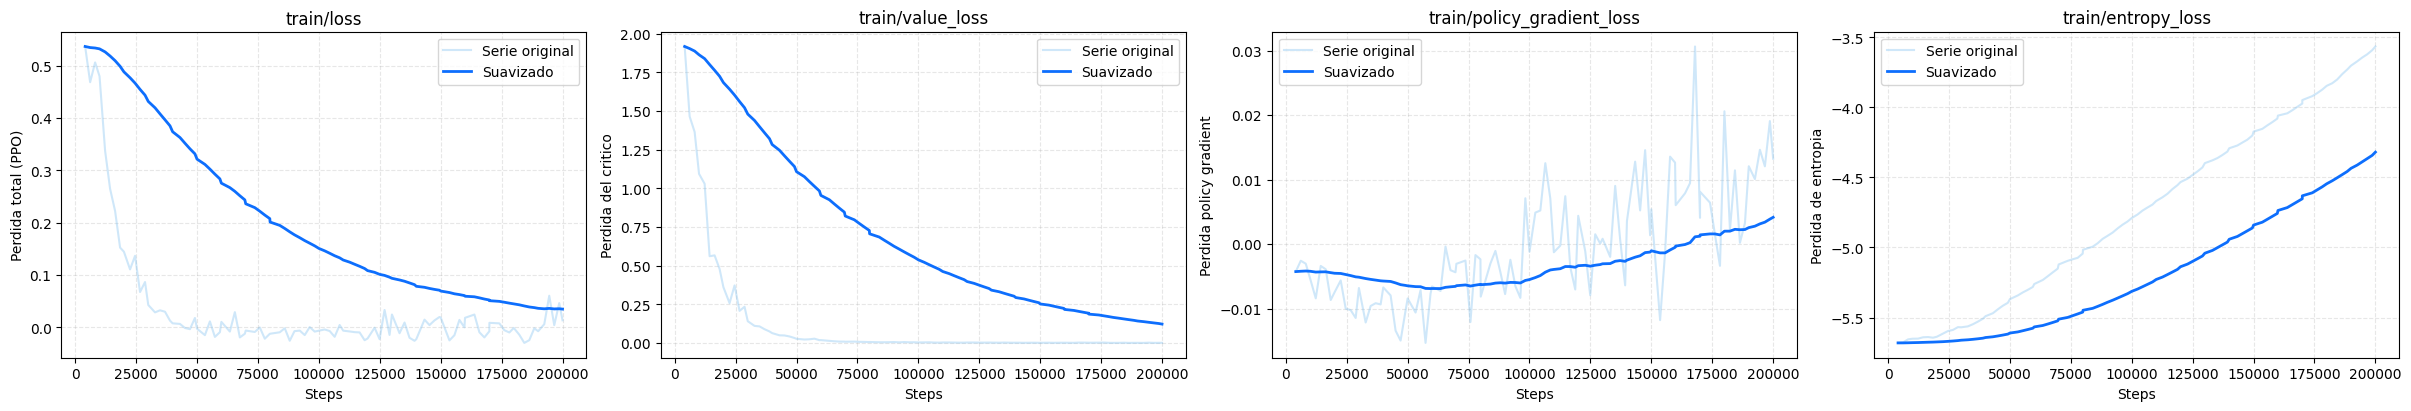

Figura de recompensa guardada en images/fetchreach_ppo_reward.png


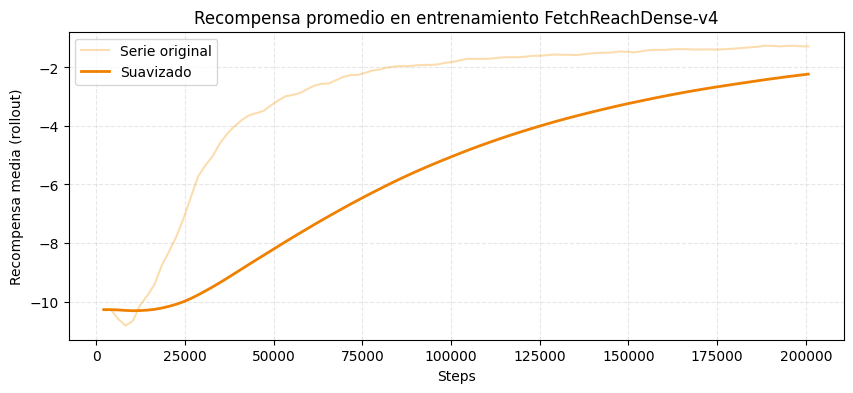

In [ ]:
# 📊 Graficas de perdidas y recompensa para FetchReachDense-v4 PPO
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
LOG_DIR = Path(f"/content/drive/MyDrive/RL_Experiments/{EXPERIMENT_NAME}")


log_roots = []
if "LOG_DIR" in globals():
    log_roots.append(Path(LOG_DIR))

log_roots.append(Path.cwd() / "runs")


# Buscar archivos .tfevents de manera recursiva
log_event_files = []
for root in log_roots:
    if root.exists():
        print("a")
        log_event_files.extend(root.rglob("events.out.tfevents.*"))

log_event_files = sorted(set(log_event_files))

if not log_event_files:
    raise FileNotFoundError("No se encontraron archivos events.out.tfevents.*; ejecuta primero el entrenamiento en Colab o verifica la ruta en Google Drive.")

print("Archivos de eventos detectados:")
for path in log_event_files:
    print(f" - {path}")

# Combinar todos los eventos en un diccionario de series
scalar_series = {}
for event_path in log_event_files:
    try:
        ea = event_accumulator.EventAccumulator(str(event_path), size_guidance={"scalars": 0})
        ea.Reload()
    except Exception as err:
        print(f"⚠️ No se pudo cargar {event_path}: {err}")
        continue

    for tag in ea.Tags().get("scalars", []):
        entries = scalar_series.setdefault(tag, [])
        entries.extend((scalar.step, scalar.value) for scalar in ea.Scalars(tag))

available_scalars = sorted(scalar_series.keys())
print("Series disponibles:")
for tag in available_scalars:
    print(f" - {tag}")

if not available_scalars:
    raise ValueError("Los eventos no contienen datos de scalars.")


def get_scalar(tag: str):
    data = scalar_series.get(tag, [])
    if not data:
        print(f"⚠️ No se encontro la serie {tag} en los eventos")
        return np.array([], dtype=np.int64), np.array([], dtype=np.float64)
    data = np.array(data, dtype=np.float64)
    steps = data[:, 0].astype(np.int64)
    values = data[:, 1]
    order = np.argsort(steps)
    return steps[order], values[order]


def smooth(values: np.ndarray, weight: float = 0.97) -> np.ndarray:
    if values.size == 0:
        return values
    smoothed = np.empty_like(values, dtype=np.float64)
    smoothed[0] = values[0]
    for idx in range(1, len(values)):
        smoothed[idx] = weight * smoothed[idx - 1] + (1.0 - weight) * values[idx]
    return smoothed

loss_candidates = [
    ("train/loss", "Perdida total (PPO)"),
    ("train/value_loss", "Perdida del critico"),
    ("train/policy_gradient_loss", "Perdida policy gradient"),
    ("train/entropy_loss", "Perdida de entropia")
]

selected_losses = [(tag, label) for tag, label in loss_candidates if tag in scalar_series]

if not selected_losses:
    print("⚠️ No se encontraron series de perdida en los eventos")
else:
    fig, axes = plt.subplots(1, len(selected_losses), figsize=(6 * len(selected_losses), 4), constrained_layout=True)
    if len(selected_losses) == 1:
        axes = [axes]

    for axis, (tag, ylabel) in zip(axes, selected_losses):
        steps, values = get_scalar(tag)
        if steps.size == 0:
            axis.text(0.5, 0.5, "Sin datos", ha="center", va="center")
            axis.axis("off")
            continue
        smooth_curve = smooth(values)
        axis.plot(steps, values, color="#76bcef", alpha=0.35, label="Serie original")
        axis.plot(steps, smooth_curve, color="#0d6efd", linewidth=2.0, label="Suavizado")
        axis.set_title(tag)
        axis.set_xlabel("Steps")
        axis.set_ylabel(ylabel)
        axis.grid(True, linestyle="--", alpha=0.3)
        axis.legend()

    loss_fig_path = Path("images") / "fetchreach_ppo_losses.png"
    try:
        loss_fig_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(loss_fig_path, dpi=150, bbox_inches="tight")
        print(f"Figura de perdidas guardada en {loss_fig_path}")
    except PermissionError as err:
        print(f"No se pudo guardar la figura de perdidas: {err}")

    plt.show()
    plt.close(fig)

steps_rew, values_rew = get_scalar("rollout/ep_rew_mean")
fig2, axis2 = plt.subplots(figsize=(10, 4))

if steps_rew.size == 0:
    axis2.text(0.5, 0.5, "Sin datos", ha="center", va="center")
    axis2.axis("off")
else:
    reward_smooth = smooth(values_rew)
    axis2.plot(steps_rew, values_rew, color="#f6a01a", alpha=0.35, label="Serie original")
    axis2.plot(steps_rew, reward_smooth, color="#f08000", linewidth=2.0, label="Suavizado")
    axis2.set_xlabel("Steps")
    axis2.set_ylabel("Recompensa media (rollout)")
    axis2.set_title("Recompensa promedio en entrenamiento FetchReachDense-v4")
    axis2.grid(True, linestyle="--", alpha=0.3)
    axis2.legend()

reward_fig_path = Path("images") / "fetchreach_ppo_reward.png"
try:
    reward_fig_path.parent.mkdir(parents=True, exist_ok=True)
    fig2.savefig(reward_fig_path, dpi=150, bbox_inches="tight")
    print(f"Figura de recompensa guardada en {reward_fig_path}")
except PermissionError as err:
    print(f"No se pudo guardar la figura de recompensa: {err}")

plt.show()
plt.close(fig2)


In [ ]:
# 📹 Evaluación y generación de video (10 segundos)
import imageio

def make_eval_env():
    """Crear entorno para evaluación y video"""
    env = gym.make(ENV_ID, render_mode='rgb_array')
    env = Monitor(env)
    return env

def load_best_model():
    """Carga el mejor modelo disponible"""
    # Buscar en orden de preferencia: best_model, último checkpoint, final_model
    model_paths = [
        os.path.join(MODEL_DIR, 'best_model.zip'),
        latest_checkpoint,
        os.path.join(MODEL_DIR, 'final_model.zip')
    ]

    for model_path in model_paths:
        if model_path and os.path.exists(model_path):
            print(f"📦 Cargando modelo desde: {model_path}")
            return PPO.load(model_path, device=device), model_path

    raise FileNotFoundError('❌ No se encontró ningún modelo guardado. Ejecuta primero el entrenamiento.')

# Cargar modelo y crear entorno de evaluación
try:
    eval_model, model_used = load_best_model()
    eval_env = make_eval_env()
    print(f"✅ Modelo cargado: {os.path.basename(model_used)}")

    if IN_COLAB:
        print(f"📁 Modelo desde Google Drive: {'✅' if '/content/drive' in model_used else '❌'}")

except FileNotFoundError as e:
    print(e)
    raise

# Configuración del video
FPS = 30
SECONDS = 10  # Duración del video
MAX_FRAMES = FPS * SECONDS

print(f"🎬 Generando video de {SECONDS} segundos ({MAX_FRAMES} frames)...")

# Generar video concatenando episodios
frames = []
rewards_all = []
rewards_ep = []
episode_count = 0

obs, info = eval_env.reset(seed=SEED)

while len(frames) < MAX_FRAMES:
    action, _ = eval_model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)
    rewards_ep.append(reward)

    # Capturar frame
    frame = eval_env.render()
    frames.append(frame)

    if terminated or truncated:
        episode_count += 1
        episode_reward = float(np.sum(rewards_ep))
        rewards_all.append(episode_reward)
        print(f"   Episodio {episode_count}: recompensa = {episode_reward:.3f}")
        rewards_ep = []
        obs, info = eval_env.reset()

# Agregar última recompensa parcial si existe
if rewards_ep:
    rewards_all.append(float(np.sum(rewards_ep)))

# Estadísticas de evaluación
if rewards_all:
    mean_reward = float(np.mean(rewards_all))
    std_reward = float(np.std(rewards_all))
    print(f"\n📊 Estadísticas de evaluación:")
    print(f"   Episodios completados: {len(rewards_all)}")
    print(f"   Recompensa media: {mean_reward:.3f} ± {std_reward:.3f}")
    print(f"   Mejor episodio: {max(rewards_all):.3f}")
    print(f"   Peor episodio: {min(rewards_all):.3f}")
else:
    print("⚠️ No se completó ningún episodio")

# Guardar video
video_path = os.path.join(VIDEO_DIR, f'ppo_eval_{SECONDS}s.mp4')
imageio.mimwrite(video_path, frames, fps=FPS)
print(f"\n🎥 Video guardado en: {video_path}")
print(f"   Duración: {len(frames)/FPS:.1f} segundos")
print(f"   Resolución: {frames[0].shape if frames else 'N/A'}")

if IN_COLAB:
    print(f"   📁 Video en Google Drive: {'✅' if '/content/drive' in video_path else '❌'}")

eval_env.close()

📦 Cargando modelo desde: /content/drive/MyDrive/RL_Experiments/FetchReachDense-v4_PPO_1758579285/models/best_model.zip
✅ Modelo cargado: best_model.zip
📁 Modelo desde Google Drive: ✅
🎬 Generando video de 10 segundos (300 frames)...
   Episodio 1: recompensa = -0.279
   Episodio 2: recompensa = -0.485
   Episodio 3: recompensa = -0.399
   Episodio 4: recompensa = -0.374
   Episodio 5: recompensa = -0.415
   Episodio 6: recompensa = -0.847

📊 Estadísticas de evaluación:
   Episodios completados: 6
   Recompensa media: -0.467 ± 0.181
   Mejor episodio: -0.279
   Peor episodio: -0.847

🎥 Video guardado en: /content/drive/MyDrive/RL_Experiments/FetchReachDense-v4_PPO_1758579285/videos/ppo_eval_10s.mp4
   Duración: 10.0 segundos
   Resolución: (480, 480, 3)
   📁 Video en Google Drive: ✅


In [ ]:
# 🎬 Reproducir y visualizar video del modelo entrenado
import os
from pathlib import Path
import base64
from IPython.display import HTML, Video, display

def find_video_file():
    """Busca el archivo de video más reciente"""
    video_files = list(Path(VIDEO_DIR).glob("*.mp4"))
    if not video_files:
        return None

    # Retornar el video más reciente
    latest_video = max(video_files, key=lambda x: x.stat().st_mtime)
    return str(latest_video)

def display_video_simple(video_path):
    """Muestra video usando método simple similar al notebook de Gymnasium Robotics"""
    try:
        if IN_COLAB:
            # Para Colab: usar HTML con base64 encoding (método simple)
            with open(video_path, 'rb') as f:
                video_bytes = f.read()

            video_b64 = base64.b64encode(video_bytes).decode()

            html = f"""
            <div style="text-align: center;">
                <h3>🎥 Video del Agente PPO Entrenado - FetchReachDense</h3>
                <video width="640" height="480" controls>
                    <source src="data:video/mp4;base64,{video_b64}" type="video/mp4">
                    Tu navegador no soporta el elemento video.
                </video>
                <p><b>Archivo:</b> {os.path.basename(video_path)}</p>
                <p><b>Tamaño:</b> {os.path.getsize(video_path) / (1024 * 1024):.1f} MB</p>
            </div>
            """
            display(HTML(html))
        else:
            # Para Jupyter local: usar IPython.display.Video
            display(Video(video_path, width=640, height=480))

        print(f"✅ Video mostrado exitosamente")
        print(f"📂 Ruta: {video_path}")

    except Exception as e:
        print(f"❌ Error mostrando video: {e}")
        print(f"🔗 Puedes abrir el video manualmente desde: {video_path}")

# Buscar y mostrar video
video_path = find_video_file()

if video_path and os.path.exists(video_path):
    print(f"🎬 Reproduciendo video del modelo entrenado...")
    display_video_simple(video_path)

    print(f"\n💡 El video muestra el comportamiento del agente PPO después del entrenamiento.")
    print(f"🤖 El robot Fetch intenta alcanzar posiciones objetivo usando su brazo robótico.")
    print(f"📈 FetchReachDense-v4 proporciona recompensas densas para un aprendizaje más eficiente.")

else:
    print("❌ No se encontró archivo de video.")
    print("⚠️ Ejecuta primero la celda de evaluación y generación de video.")
    print(f"📁 Directorio de videos: {VIDEO_DIR}")

    # Listar archivos disponibles
    if os.path.exists(VIDEO_DIR):
        video_files = list(Path(VIDEO_DIR).glob("*"))
        if video_files:
            print(f"📂 Archivos encontrados en {VIDEO_DIR}:")
            for file in video_files:
                print(f"   - {file.name}")
        else:
            print(f"📂 El directorio {VIDEO_DIR} está vacío.")
    else:
        print(f"📂 El directorio {VIDEO_DIR} no existe.")

🎬 Reproduciendo video del modelo entrenado...


✅ Video mostrado exitosamente
📂 Ruta: /content/drive/MyDrive/RL_Experiments/FetchReachDense-v4_PPO_1758579285/videos/ppo_eval_10s.mp4

💡 El video muestra el comportamiento del agente PPO después del entrenamiento.
🤖 El robot Fetch intenta alcanzar posiciones objetivo usando su brazo robótico.
📈 FetchReachDense-v4 proporciona recompensas densas para un aprendizaje más eficiente.
